## 의미 객체 인식

In [1]:
dir_data = 'dataset1/'
dir_seg = dir_data + '/annotations_prepped_train/'
dir_img = dir_data + '/images_prepped_train/'

In [2]:
import glob, os
all_img_paths = glob.glob(os.path.join(dir_img, '*.png'))
all_img_paths[-5:]

['dataset1//images_prepped_train\\0016E5_08520.png',
 'dataset1//images_prepped_train\\0016E5_08550.png',
 'dataset1//images_prepped_train\\0016E5_08580.png',
 'dataset1//images_prepped_train\\0016E5_08610.png',
 'dataset1//images_prepped_train\\0016E5_08640.png']

In [3]:
all_mask_paths = glob.glob(os.path.join(dir_seg, '*.png'))
all_mask_paths[:5]

['dataset1//annotations_prepped_train\\0001TP_006690.png',
 'dataset1//annotations_prepped_train\\0001TP_006720.png',
 'dataset1//annotations_prepped_train\\0001TP_006750.png',
 'dataset1//annotations_prepped_train\\0001TP_006780.png',
 'dataset1//annotations_prepped_train\\0001TP_006810.png']

In [41]:
x = []
y = []
count = 0

In [42]:
import cv2
import imageio
for i in range(len(all_img_paths)):
    img = cv2.imread(all_img_paths[i])
    img = cv2.resize(img, (224, 224))
    mask_path = dir_seg+all_img_paths[i].split('\\')[-1]
    img_mask = imageio.imread(mask_path) # Changed to skimage read
    img_mask = cv2.resize(img_mask, (224, 224))
    x.append(img)
    y.append(img_mask)
    if(i%100==0):
        print(i)

0
100
200
300


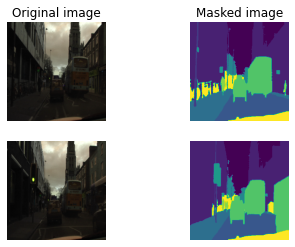

In [11]:
import matplotlib.pyplot as plt

plt.subplot(221)
plt.imshow(x[3])
plt.axis('off')
plt.title('Original image')
plt.grid('off')

plt.subplot(222)
plt.imshow(y[3])
plt.axis('off')
plt.title('Masked image')
plt.grid('off')

plt.subplot(223)
plt.imshow(x[1])
plt.axis('off')
plt.grid('off')

plt.subplot(224)
plt.imshow(y[1])
plt.axis('off')
plt.grid('off')
plt.show()

In [13]:
import numpy as np
set(np.array(y).flatten())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [14]:
np.array(y).shape

(367, 224, 224)

In [15]:
n_classes = len(set(np.array(y).flatten()))
n_classes

12

In [43]:
np.array((y[1]==1).astype(int)).shape

(224, 224)

In [56]:
def getsegnum(img):
    seg_labels = np.zeros((224,224, 12))
    for c in range(12):
        seg_labels[:, :, c] = (img == c).astype(int)
    return seg_labels

In [57]:
y2 = []
for i in range(len(y)):
    y2.append(getsegnum(y[i]))

In [58]:
x = np.array(x)
y2 = np.array(y2)
print(x.shape, y2.shape)
print(np.unique(y2))

(367, 224, 224, 3) (367, 224, 224, 12)
[0. 1.]


In [59]:
x = x/255
print(np.max(x))

1.0


In [60]:
from tensorflow.keras.applications.vgg16 import VGG16
base_vgg16 = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_vgg16.trainable = False
# base_vgg16.summary()

In [61]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [62]:
conv1 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block1_conv2').output).output
conv2 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block2_conv2').output).output
conv3 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block3_conv3').output).output
conv4 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block4_conv3').output).output
drop4 = Dropout(0.5)(conv4)
conv5 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block5_conv3').output).output
drop5 = Dropout(0.5)(conv5)

In [63]:
up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
merge6 = concatenate([drop4, up6], axis=-1)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

In [64]:
up7 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
merge7 = concatenate([conv3, up7], axis=-1)
conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

In [65]:
up8 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
merge8 = concatenate([conv2, up8], axis=-1)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

In [66]:
up9 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
merge9 = concatenate([conv1, up9], axis=-1)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

In [67]:
conv10 = Conv2D(12, 1, activation='softmax')(conv9)

In [68]:
model = Model(inputs=base_vgg16.input, outputs=conv10)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [69]:
for layer in model.layers[:18]:
    layer.trainable = False

In [70]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3, decay=1e-6), metrics=['accuracy'])

In [ ]:
history = model.fit(x, y2, epochs=10, batch_size=1, validation_split=0.1)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='training accuracy')
plt.plot(epochs, val_acc, 'bo', label='validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'bo', label='validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(x[-2:])
y_predi = np.argmax(y_pred, axis=-1)
y_testi = np.argmax(y2[-2:], axis=-1)

In [ ]:
np.mean(y_predi == y_testi)

In [ ]:
plt.subplot(231)
plt.imshow(x[-1])
plt.axis('off')
plt.title('Original image')
plt.grid('off')
plt.subplot(232)
plt.imshow(y2[-1,:,:,0])
plt.axis('off')
plt.title('Actual mask image')
plt.grid('off')
plt.subplot(233)
plt.imshow(y_pred[-1,:,:,0])
plt.axis('off')
plt.title('Predicted mask image')
plt.grid('off')

plt.subplot(234)
plt.imshow(x[-2])
plt.axis('off')
plt.grid('off')
plt.subplot(235)
plt.imshow(y2[-2,:,:,0])
plt.axis('off')
plt.grid('off')
plt.subplot(236)
plt.imshow(y_pred[-2,:,:,0])
plt.axis('off')
plt.grid('off')

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model1.png')